# Defining complete experiment

In [1]:
from scipy.stats import expon
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from scipy.stats import norm

### model

In [6]:
num_categories = 5

In [7]:
model = np.ones((num_categories))/num_categories

### Ideal model

In [8]:
xx = np.arange(1,num_categories+1,1)
print(xx)

[1 2 3 4 5]


In [9]:
values = 1-expon.cdf(x=xx, scale=1)

In [10]:
values_norm = values/np.sum(values)
print(values_norm)

[0.63640865 0.23412166 0.08612854 0.03168492 0.01165623]


In [11]:
np.sum(values_norm)

1.0

In [12]:
model_i = values_norm

### Q_i

In [13]:
q_i = np.zeros((num_categories))

In [14]:
for i in range(num_categories):
  q_i[i] = 0.5 if i == 0 else q_i[i-1]/2

In [15]:
q_i_norm3 = q_i**2/np.sum(q_i**2)

In [16]:
q_i_norm = 1 - q_i_norm3

In [17]:
# We have only 1 action, because it has no influence on our process

def ideal_decision(num_categories: int, action: int, prev_state: int) -> float:
    num_states = num_categories
    num_actions = 1
    id_dec = np.ones((num_states, num_actions))
    return id_dec[prev_state, action]


def model_prob(state: int, stop_state: int, action: int, stop_action: int,
               prev_state: int, prev_stop_state: int, model: np.ndarray) -> float:
    """
    m(s_{t},\StSt_{t}|a_{t},\StAc_{t},s_{t-1},\StSt_{t-1})
    :param state:
    :param stop_state:
    :param action:
    :param stop_action:
    :param prev_state:
    :param prev_stop_state:
    :return:
    """
    if stop_action == stop_state:
        if stop_state == 1:
            # if already did not stop the process
            return model[state]
        else:
            # if the process is already stopped e.g. prev_stop_state == 0
            return 1 if prev_state == state else 0
    else:
        return 0


def model_ideal_prob(state: int, stop_state: int, action: int, stop_action: int,
                     prev_state: int, prev_stop_state: int, model: np.ndarray, 
                     model_i: np.ndarray) -> float:
    """
    m^{i}(s_{t},\StSt_{t}|a_{t},\StAc_{t},s_{t-1},\StSt_{t-1})
    :param state:
    :param stop_state:
    :param action:
    :param stop_action:
    :param prev_state:
    :param prev_stop_state:
    :return:
    """
    if stop_action == stop_state:
        if stop_action == 1:
            # if process should continue we return ideal model
            return model_i[state]
        else:
            # if the process should stop we don't care about ideal and let it be same as modelled
            if stop_state == 1:
                # if already did not stop the process
                return model[state]
            else:
                # if the process is already stopped e.g. prev_stop_state == 0
                return 1 if prev_state == state else 0
    else:
        return 0


def ideal_decision_rule(num_states: int, action: int, stop_action: int, prev_state: int,
                        prev_stop_state: int, q_i: np.ndarray) -> np.ndarray:
    """
    Ideal decision rule as defined as in my text work
    :param action:
    :param stop_action:
    :param prev_state:
    :param prev_stop_state:
    :return: one value based on inputs
    """
    num_actions = 1
    first_element = ideal_decision(num_states, action, prev_state) if stop_action == 1 \
        else 1/num_actions
    # as else value we used uniform action selection
    if prev_stop_state == 0:
        second_element = 1 if stop_action == 0 else 0
    else:
      # if prob we CONTINUE else we STOP
        second_element = q_i[prev_state] if stop_action == 1 else 1 - q_i[prev_state]

    final_output = first_element * second_element
    return final_output


def h_fun(num_states: int, time: int, state: int, stop_state: int, q_i: np.ndarray, d_storage: np.ndarray) -> float: #or maybe -> np.ndarray?
    """
    Calculates h function values based on previous d function values and ideal decision rule
    :param time:
    :param state:
    :param stop_state:
    :return:
    """
    output = 0
    num_actions = 1
    num_stop_actions = 2

    for i in range(num_actions):
        for stop in range(num_stop_actions):
            output += ideal_decision_rule(num_states, i, stop, state, stop_state, q_i) * \
                      np.exp(-d_storage[time+1, i, stop, state, stop_state])
    return output


def d_fun(time: int, action: int, stop_action: int, prev_state: int, 
          prev_stop_state: int, model: np.ndarray, model_i: np.ndarray, num_states: int, h_storage: np.ndarray) -> float:
    """
    \mathsf{d}(a_{t},\StAc_{t},s_{t-1},\StSt_{t-1}) as defined in text
    :param time:
    :param action:
    :param stop_action:
    :param prev_state:
    :param prev_stop_state:
    :return:
    """
    output = 0
    num_stop_states = 2
    for i in range(num_states):
        for stop in range(num_stop_states):
            model_reg = model_prob(i, stop, action, stop_action, prev_state, prev_stop_state, model)
            id_mod = model_ideal_prob(i, stop, action, stop_action, prev_state, 
                                      prev_stop_state, model, model_i)
            # print(id_mod)
            if model_reg == 0:
                output += 0
            else:
                output += model_reg*np.log(model_reg/(id_mod*h_storage[time, i, stop]))
    fun_output = output
    return fun_output


def normalize_d_fun() -> float:
    pass


def optimal_policy(num_actions: int, num_stop_actions: int, num_states: int, num_stop_states: int, h_stored: np.ndarray,
                   d_stored: np.ndarray, q_i: np.ndarray) -> np.ndarray:
    t_len = np.shape(h_stored)[0]
    opt_policy = np.zeros((t_len, num_actions, num_stop_actions, num_states, num_stop_states))
    for t in range(t_len-1, -1, -1):
        for action in range(num_actions):
            for stop_action in range(num_stop_actions):
                for state in range(num_states):
                    for stop_state in range(num_stop_states):
                        opt_policy[t, action, stop_action, state, stop_state] = \
                            ideal_decision_rule(num_states, action, stop_action, state, stop_state, q_i) * \
                            (np.exp(-d_stored[t, action, stop_action, state, stop_state]) /
                             h_stored[t, state, stop_state])
    #print(np.shape(opt_policy))
    return opt_policy

In [18]:
def init_experiment(horizon: int, model: np.ndarray, num_categories: int) -> np.ndarray:
  # maybe adding SEED?
  return np.random.choice(np.arange(0, num_categories), p = model, size = horizon)

In [19]:
def stopping_decision(t: int, action: int, state: int, stop_state: int, policy: np.ndarray) -> int:
  p_stop = policy[t, action, 0, state, stop_state]
  #print(p_stop)
  stop_action = np.random.choice(np.arange(0, 2), p = [p_stop, 1-p_stop])
  return stop_action

In [20]:
def single_experiment(num_categories: int, horizon: int, 
                      stop_action_sequence: np.ndarray, selected_state_sequence: np.ndarray,
                      policy: np.ndarray):
  state_sequence = init_experiment(horizon, model, num_categories)
  # we init proces to not be stopped at the beginning
  stop_action = 1
  stop_state = 1
  cur_stop_action = 1
  prev_stop = 1
  cur_state = 0
  index_stop = horizon
  # because there is none other
  action = 0
  for t in range(horizon):
    cur_stop_action = stopping_decision(t, action, state_sequence[t], stop_state, policy)
    if prev_stop != cur_stop_action:
      selected_state = state_sequence[t]
    if cur_stop_action == 1:
      # process continues
      cur_state = state_sequence[t]
    else:
      cur_state = selected_state
    stop_action_sequence[t] = cur_stop_action
    selected_state_sequence[t] = cur_state
    prev_stop = cur_stop_action
    stop_state = cur_stop_action

  return state_sequence

In [21]:
def calculate_h_d_fun(t_init: int, num_states: int, num_stop_states: int, 
                      num_actions: int, num_stop_actions: int, 
                      h_storage: np.ndarray, d_storage: np.ndarray, q_i: np.ndarray,
                      model: np.ndarray, model_i: np.ndarray):
  for t_ind in range(t_init, -1, -1):
    if t_ind != t_init:
        for state in range(num_states):
            for stop_state in range(num_stop_states):
                h_storage[t_ind, state, stop_state] = h_fun(num_states, t_ind, state, stop_state, q_i, d_storage) # h_fun(t_ind+1, state, stop_state)

    # range(start, stop, step)
    for action in range(num_actions):
        for stop_action in range(num_stop_actions):
            for state in range(num_states):
                for stop_state in range(num_stop_states):
                    d_storage[t_ind, action, stop_action, state, stop_state] = \
                        d_fun(t_ind, action, stop_action, state, stop_state, model, model_i, num_states, h_storage)

In [22]:
def plot_opt_policy(num_categories: int, low: int, high: int, policy: np.ndarray):
  for state in range(num_categories):
    plt.plot(policy[low:high, 0, 0, state, 1], label = str(state))
  plt.title('Optimal policy of taking stopping action based on current secretary')
  plt.legend(loc ="lower left")
  plt.grid()
  plt.savefig(str(num_categories)+'myimage.jpg', format='jpg', dpi=600)
  plt.show()

In [23]:
def plot_final_action(stop_action_taken: np.ndarray):
  bin = np.arange(-0.5, np.max(stop_action_taken)+1, 1)  # The edges
  plt.hist(stop_action_taken, bins=bin, rwidth=0.85)
  plt.title('In which round we decided to select the secretary')
  plt.grid()
  plt.savefig(str(num_categories)+'final_action.jpg', format='jpg', dpi=600)
  plt.show()

In [24]:
def plot_final_states(fin_selected_states: np.ndarray):
  bin = np.arange(-0.5, np.max(fin_selected_states)+1, 1)  # The edges
  plt.hist(fin_selected_states, bins = bin, rwidth=0.85)
  plt.title('Selected secretaries')
  plt.grid()
  plt.savefig(str(num_categories)+'final_selected_states.jpg', format='jpg', dpi=600)
  plt.show()

In [25]:
def experiment2(model: np.ndarray, model_i: np.ndarray, num_categories: int,
               q_i: np.ndarray, horizon: int, num_sim: int):
  # Initi phase:
  num_actions = 1
  num_stop_actions = 2
  num_stop_states = 2
  num_states = num_categories # 10
  d_storage = np.zeros((horizon, num_actions, num_stop_actions, num_states, num_stop_states))
  h_storage = np.zeros((horizon, num_states, num_stop_states))
  id_dec = np.ones((num_states, num_actions))

  state_sequence = np.zeros((num_sim, horizon))
  selected_state_sequence = np.zeros((num_sim, horizon))
  stop_action_sequence = np.ones((num_sim, horizon))
  cost_sequence = np.zeros((num_sim, horizon))
  
  # Start of the backpropagation
  h_init = 1
  h_storage[-1] = h_init
  # We initialize time index
  t_init = horizon - 1
  t = t_init
  # Calculation opt_policy
  calculate_h_d_fun(t_init, num_states, num_stop_states, num_actions, 
                    num_stop_actions, h_storage, d_storage, q_i, model, model_i)
  # Calculating and saving optimal_policy
  opt_policy = optimal_policy(num_actions, num_stop_actions, num_states, num_stop_states, h_storage, d_storage, q_i)
  plot_opt_policy(num_categories, 1, horizon, opt_policy)
  
  # MC experiment
  for i in range(num_sim):
    state_sequence[i] = single_experiment(num_categories, horizon, stop_action_sequence[i], selected_state_sequence[i], opt_policy)
  fin_selected_states = selected_state_sequence[:,-1]
  stop_action_taken = np.zeros((num_sim))
  for j in range(num_sim):
    stop_action_taken[j] = np.where(stop_action_sequence[j] == 0)[0][0]
  plot_final_action(stop_action_taken)
  plot_final_states(fin_selected_states)

  return stop_action_sequence, state_sequence


### Experiments with uniform model dist

In [26]:
model

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [27]:
model_i

array([0.63640865, 0.23412166, 0.08612854, 0.03168492, 0.01165623])

In [28]:
q_i_norm

array([0.24926686, 0.81231672, 0.95307918, 0.98826979, 0.99706745])

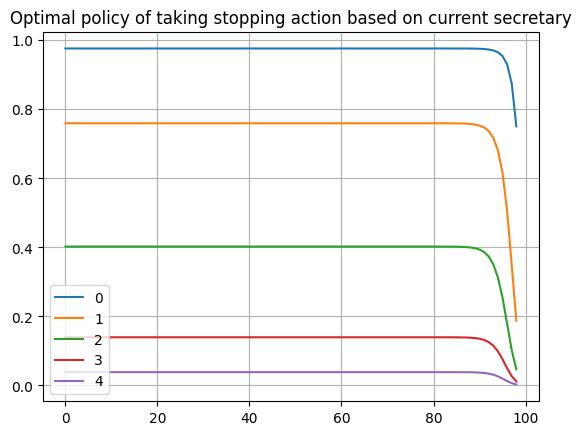

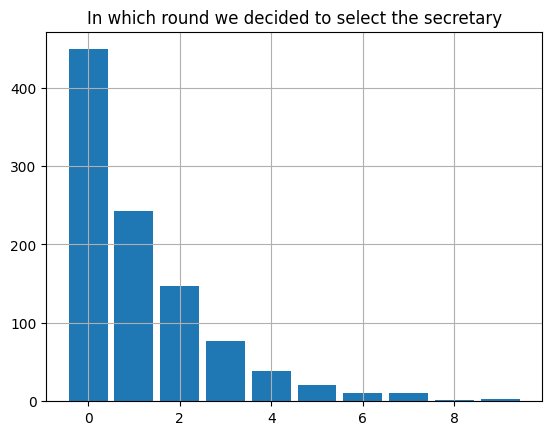

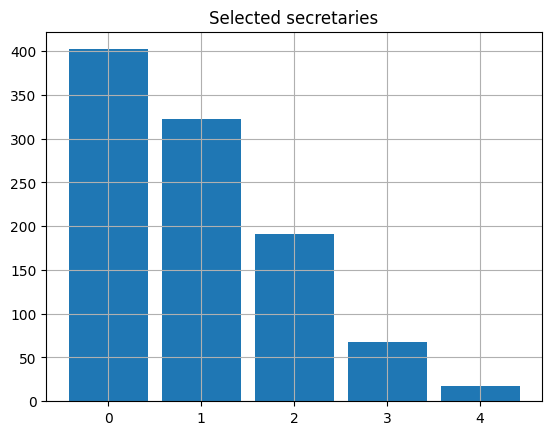

In [30]:
var = experiment2(model, model_i, num_categories, q_i_norm, 100, 1000)

In [31]:
model_i

array([0.63640865, 0.23412166, 0.08612854, 0.03168492, 0.01165623])

In [32]:
q_i = 1 - model_i
q_i

array([0.36359135, 0.76587834, 0.91387146, 0.96831508, 0.98834377])

In [33]:
model_i

array([0.63640865, 0.23412166, 0.08612854, 0.03168492, 0.01165623])

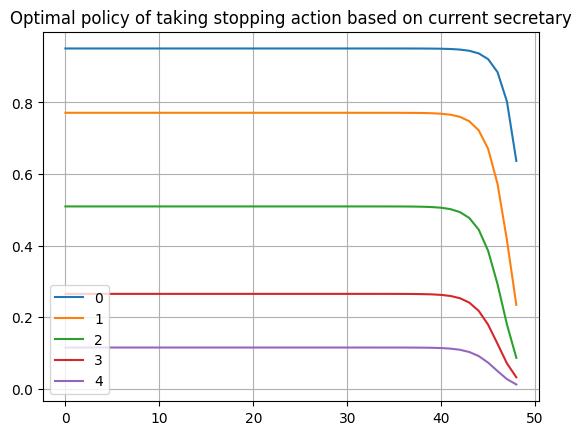

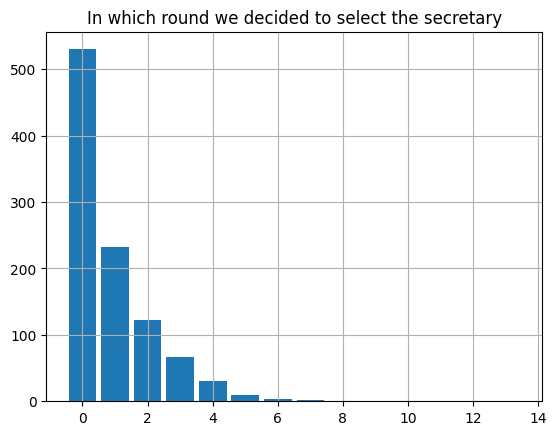

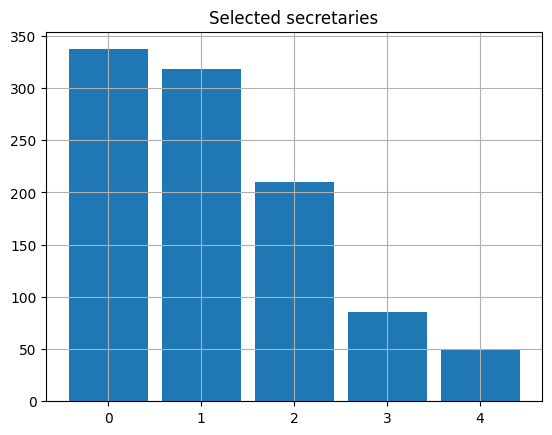

In [34]:
var = experiment2(model, model_i, num_categories, q_i, 50, 1000)

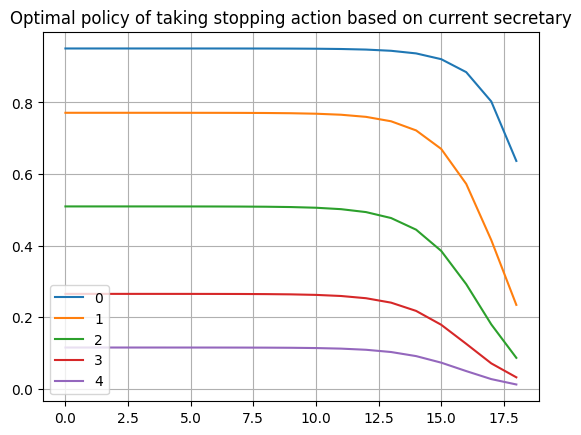

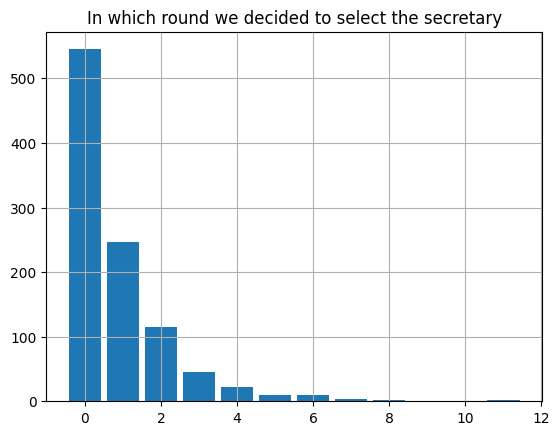

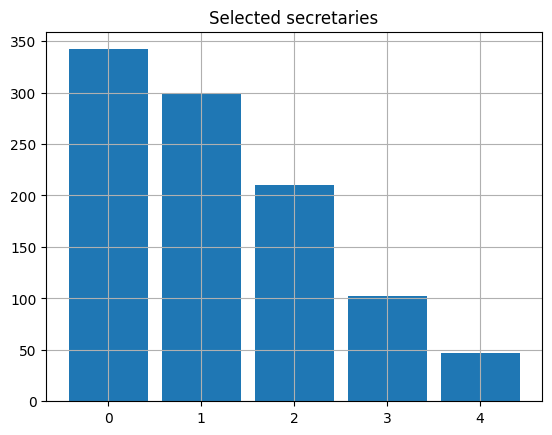

In [35]:
var = experiment2(model, model_i, num_categories, q_i, 20, 1000)

In [36]:
model_i2 = model_i**2/np.sum(model_i**2)
model_i2

array([8.64703974e-01, 1.17024957e-01, 1.58376057e-02, 2.14338686e-03,
       2.90075868e-04])

In [37]:
model

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [38]:
q_i

array([0.36359135, 0.76587834, 0.91387146, 0.96831508, 0.98834377])

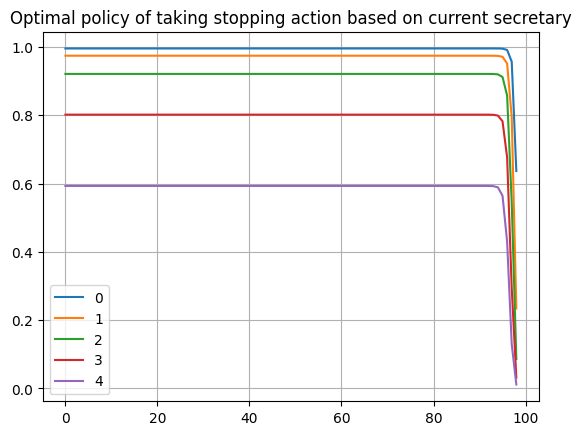

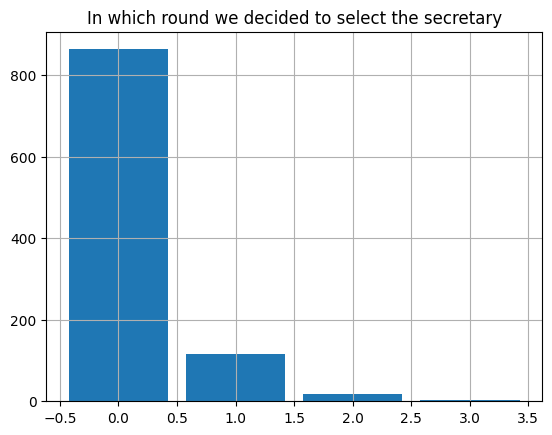

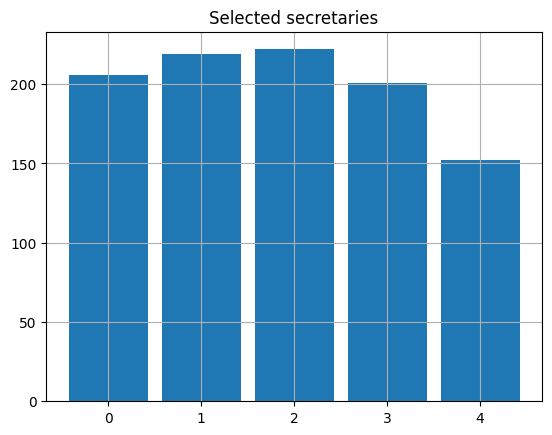

In [39]:
var = experiment2(model, model_i2, num_categories, q_i, 100, 1000)

In [40]:
model

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [41]:
model_i2

array([8.64703974e-01, 1.17024957e-01, 1.58376057e-02, 2.14338686e-03,
       2.90075868e-04])

In [42]:
q_i_uniform = np.array([0.9, 0.7, 0.5, 0.3, 0.1])

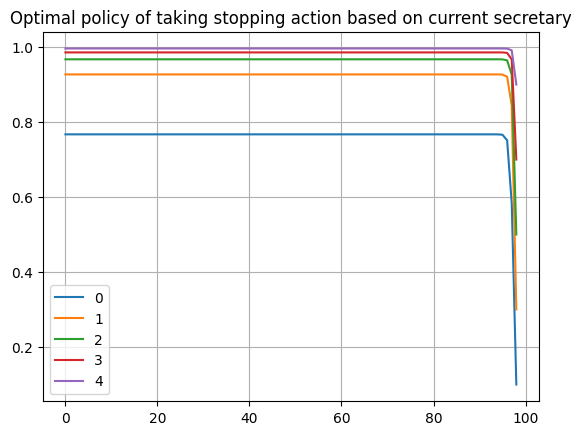

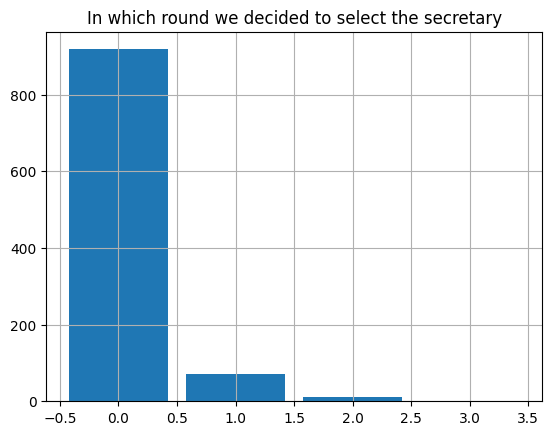

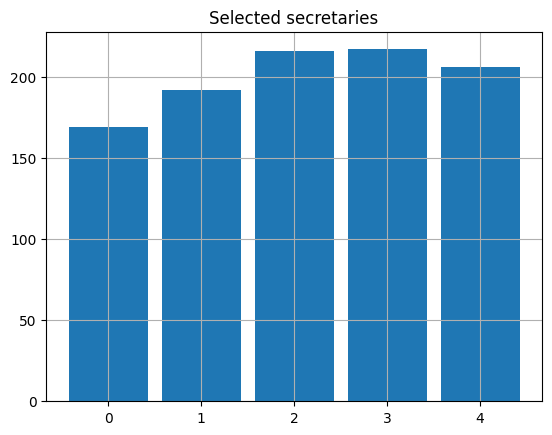

In [43]:
var = experiment2(model, model_i2, num_categories, q_i_uniform, 100, 1000)

In [44]:
q_i_uni = 1 - q_i_uniform

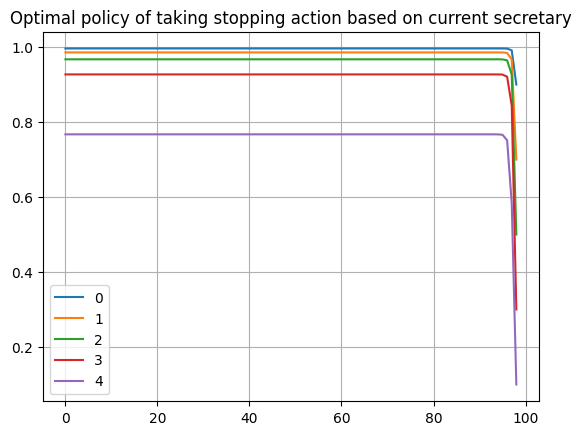

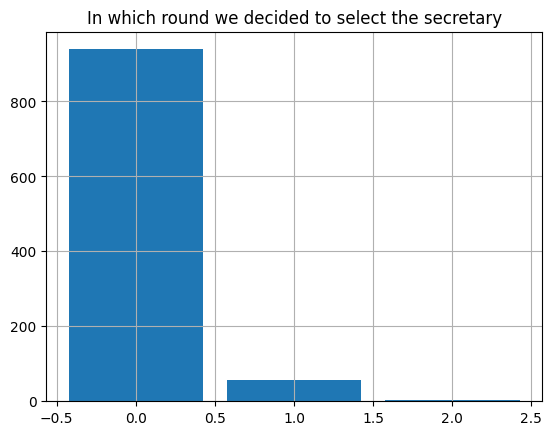

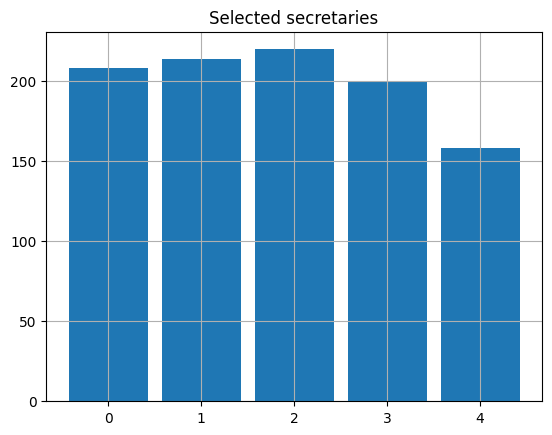

In [47]:
var = experiment2(model, model_i2, num_categories, q_i_uni, 100, 1000)

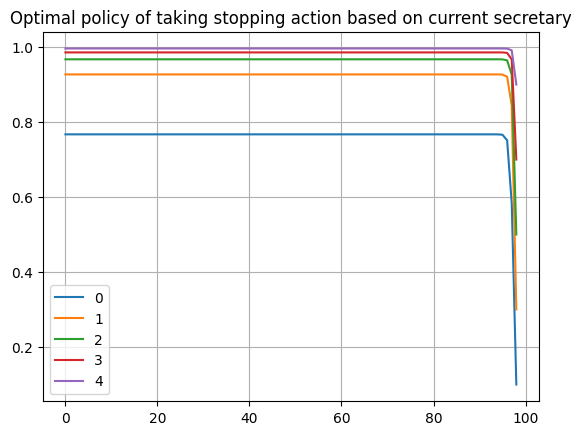

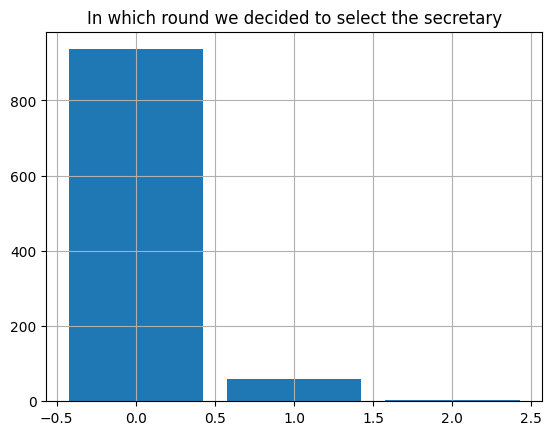

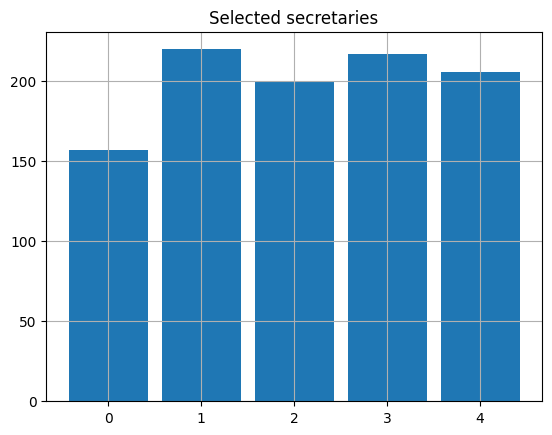

In [46]:
var = experiment2(model, model_i2, num_categories, q_i_uniform, 100, 1000)

In [48]:
q_i2 = 1 - model_i2
q_i2

array([0.13529603, 0.88297504, 0.98416239, 0.99785661, 0.99970992])

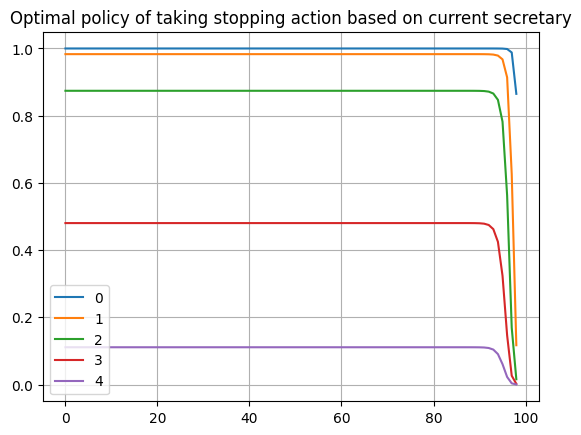

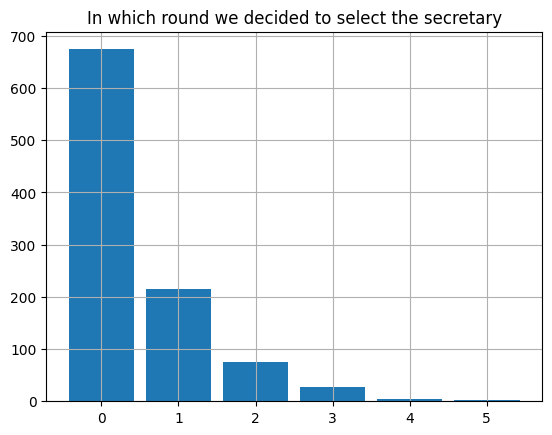

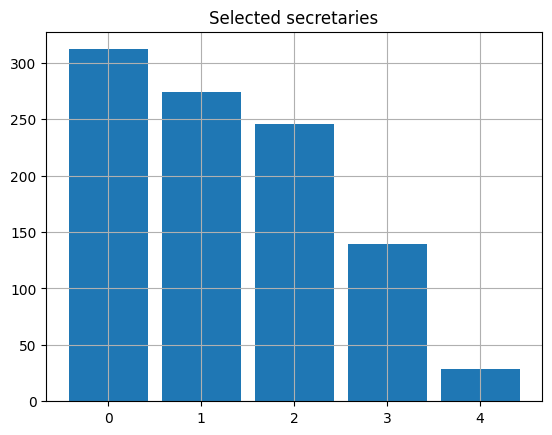

In [49]:
var = experiment2(model, model_i2, num_categories, q_i2, 100, 1000)

In [50]:
q_i3 = 1 - model_i**3/np.sum(model_i**3)
q_i3

array([0.04978678, 0.95269167, 0.99764466, 0.99988273, 0.99999416])

In [51]:
model_i2

array([8.64703974e-01, 1.17024957e-01, 1.58376057e-02, 2.14338686e-03,
       2.90075868e-04])

In [52]:
1 - q_i3

array([9.50213222e-01, 4.73083307e-02, 2.35534309e-03, 1.17265628e-04,
       5.83831182e-06])

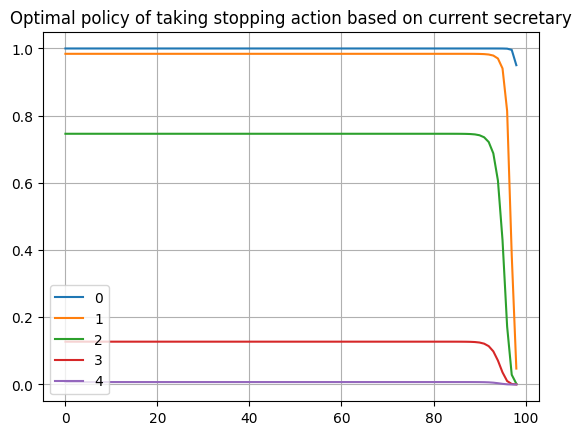

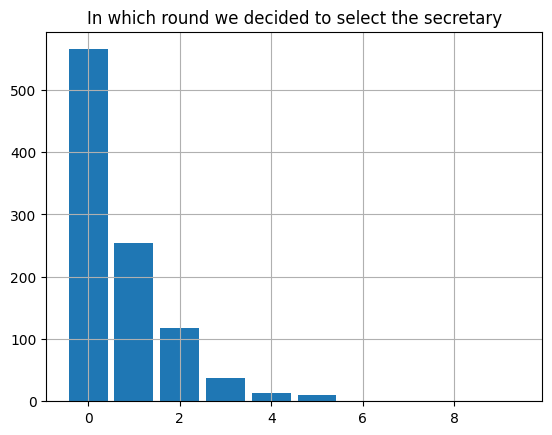

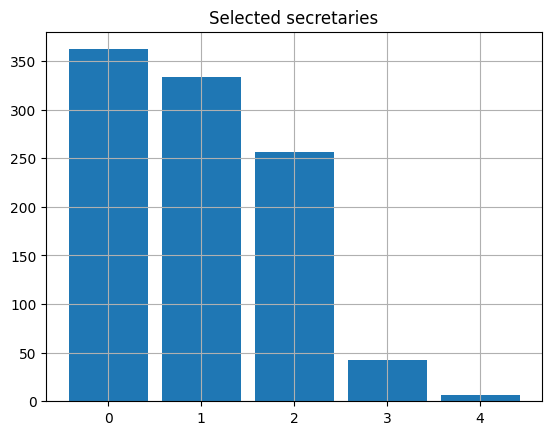

In [53]:
var = experiment2(model, model_i2, num_categories, q_i3, 100, 1000)

### Normal dist

In [54]:
xx = np.arange(1,num_categories + 1,1)

In [55]:
xx

array([1, 2, 3, 4, 5])

In [56]:
values = norm.pdf(xx, loc=3, scale=1)

In [57]:
values

array([0.05399097, 0.24197072, 0.39894228, 0.24197072, 0.05399097])

In [58]:
values_norm = values/np.sum(values)
print(values_norm)

[0.05448868 0.24420134 0.40261995 0.24420134 0.05448868]


In [59]:
model_gaus = values_norm

In [60]:
q_i_norm

array([0.24926686, 0.81231672, 0.95307918, 0.98826979, 0.99706745])

In [61]:
1 - q_i_norm

array([0.75073314, 0.18768328, 0.04692082, 0.01173021, 0.00293255])

In [62]:
model_i

array([0.63640865, 0.23412166, 0.08612854, 0.03168492, 0.01165623])

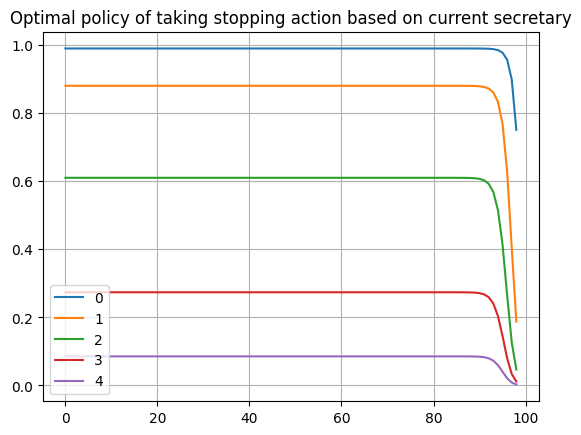

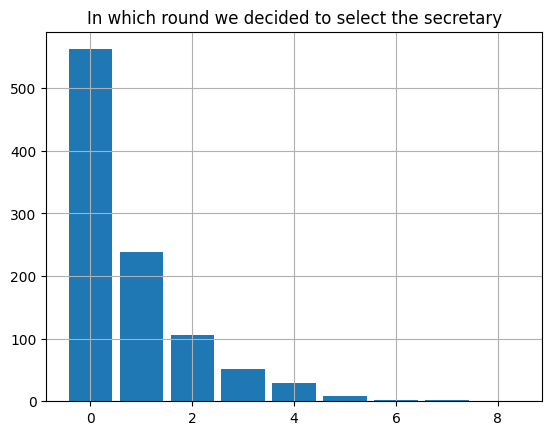

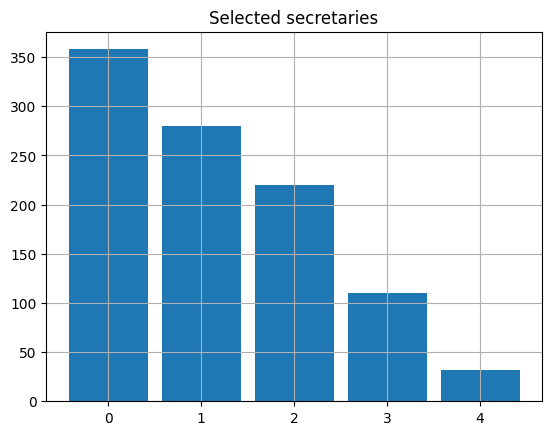

In [63]:
var = experiment2(model_gaus, model_i, num_categories, q_i_norm, 100, 1000)

In [64]:
model_i2

array([8.64703974e-01, 1.17024957e-01, 1.58376057e-02, 2.14338686e-03,
       2.90075868e-04])

In [65]:
q_i3

array([0.04978678, 0.95269167, 0.99764466, 0.99988273, 0.99999416])

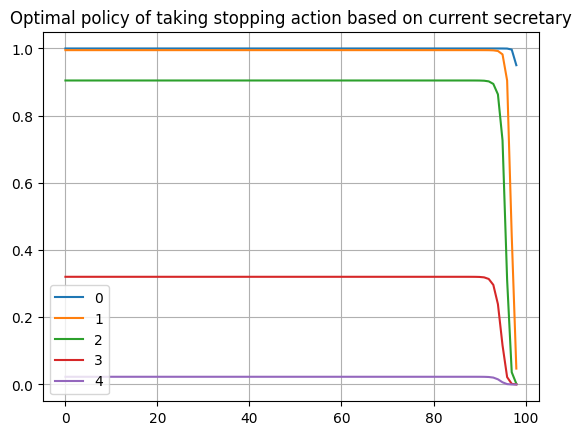

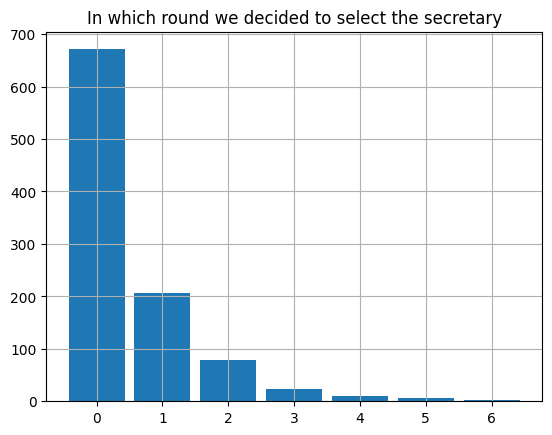

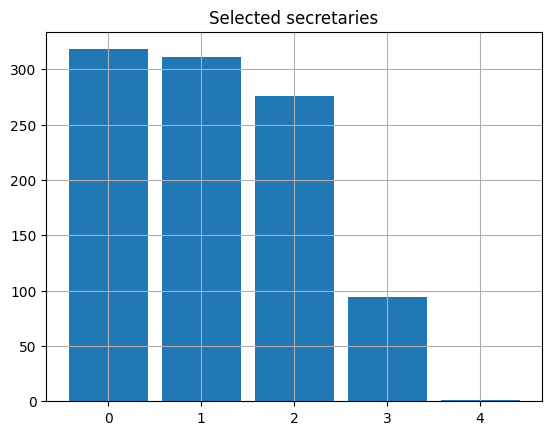

In [66]:
var = experiment2(model_gaus, model_i2, num_categories, q_i3, 100, 1000)

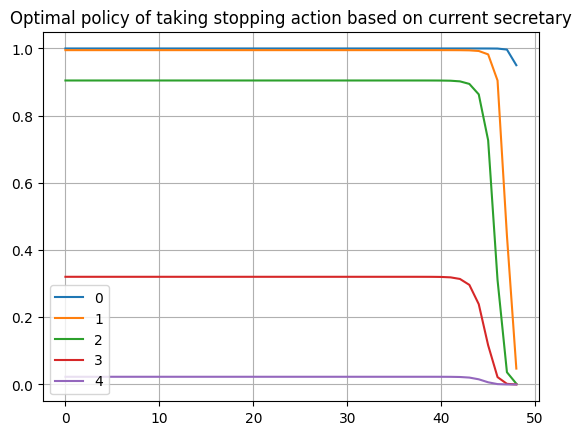

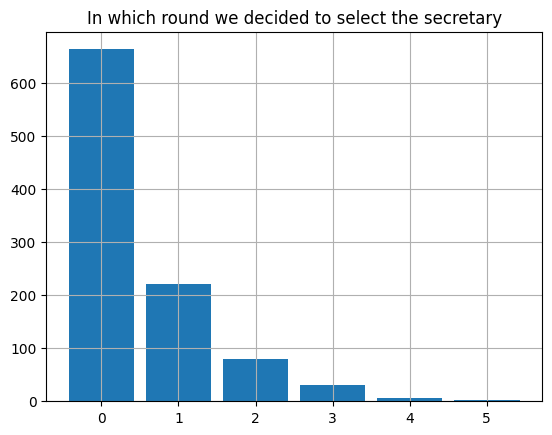

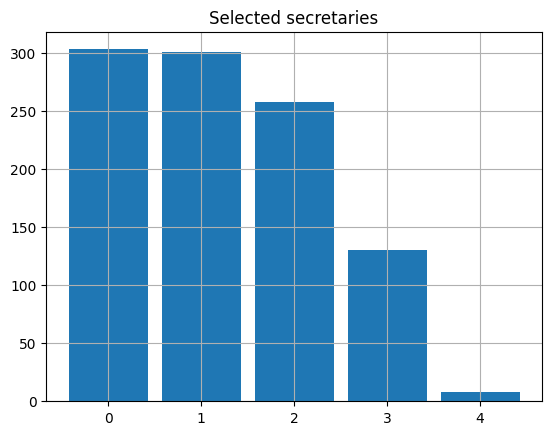

In [67]:
var = experiment2(model_gaus, model_i2, num_categories, q_i3, 50, 1000)

In [68]:
q_i2

array([0.13529603, 0.88297504, 0.98416239, 0.99785661, 0.99970992])

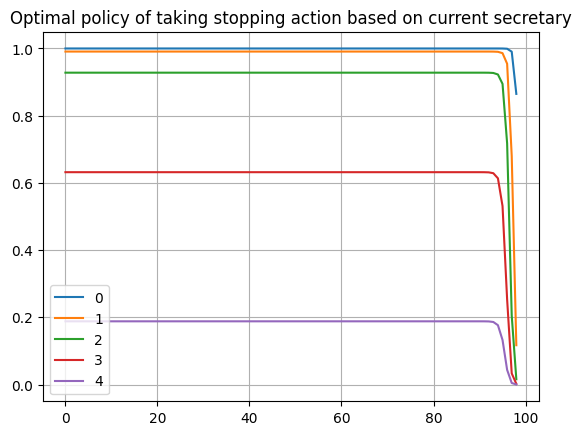

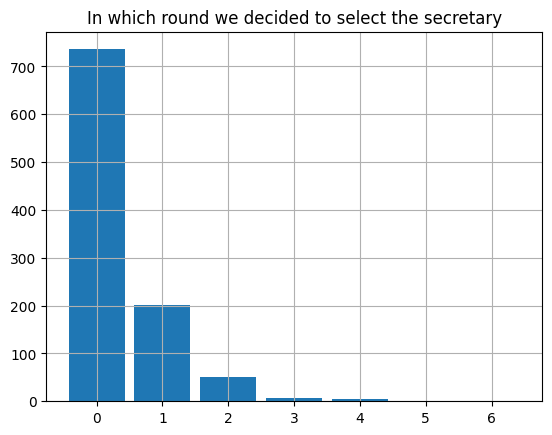

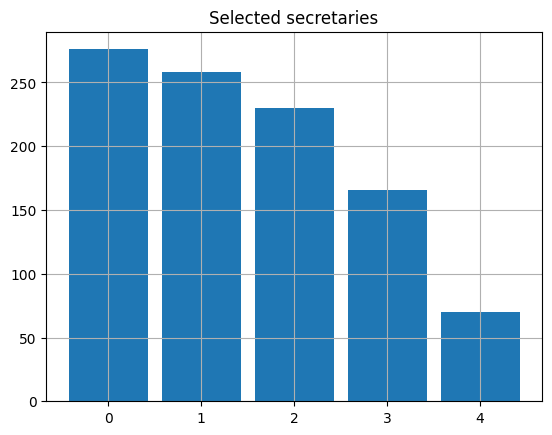

In [69]:
var = experiment2(model_gaus, model_i2, 5, q_i2, 100, 1000)

In [70]:
q_i

array([0.36359135, 0.76587834, 0.91387146, 0.96831508, 0.98834377])

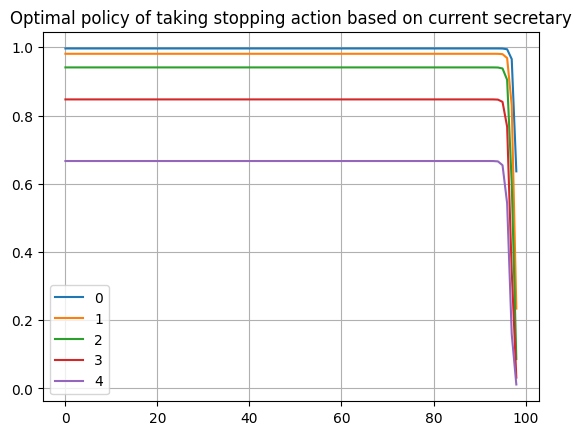

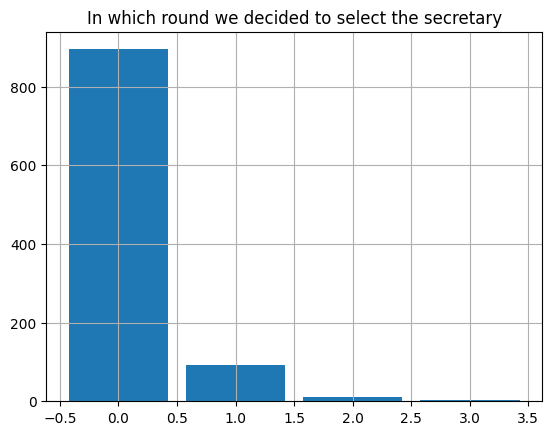

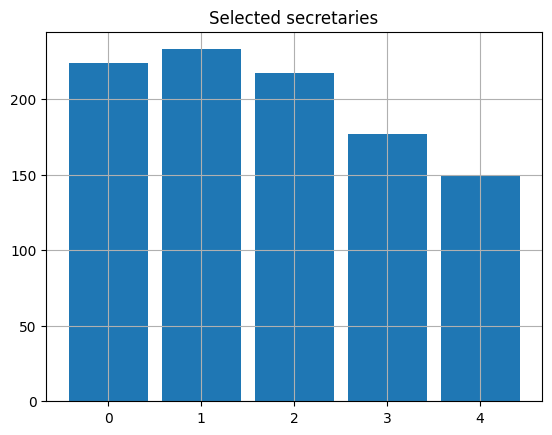

In [72]:
var = experiment2(model_gaus, model_i2, num_categories, q_i, 100, 1000)

In [73]:
model_i

array([0.63640865, 0.23412166, 0.08612854, 0.03168492, 0.01165623])

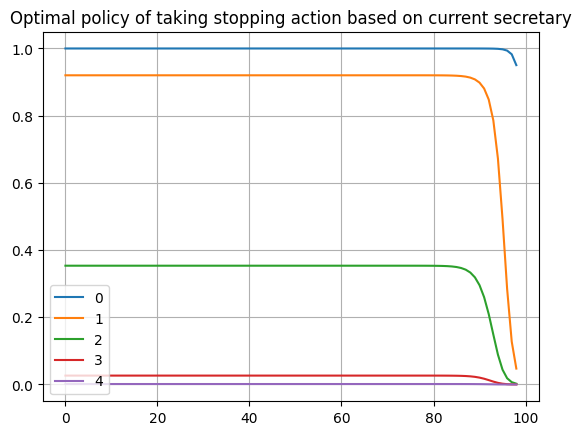

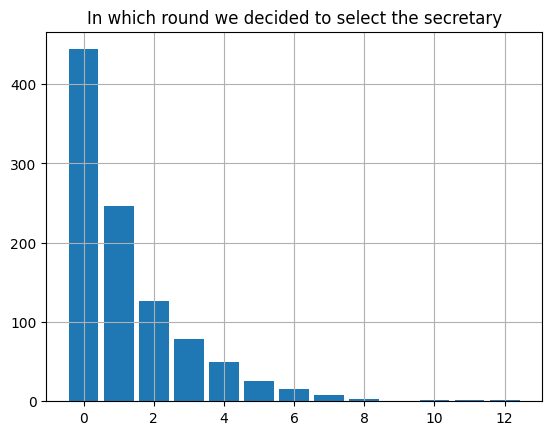

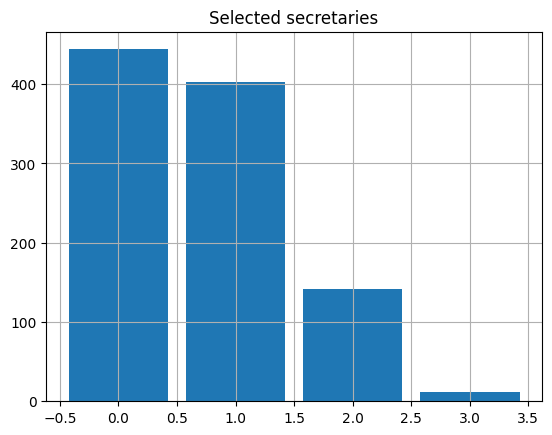

In [74]:
var = experiment2(model_gaus, model_i, num_categories, q_i3, 100, 1000)

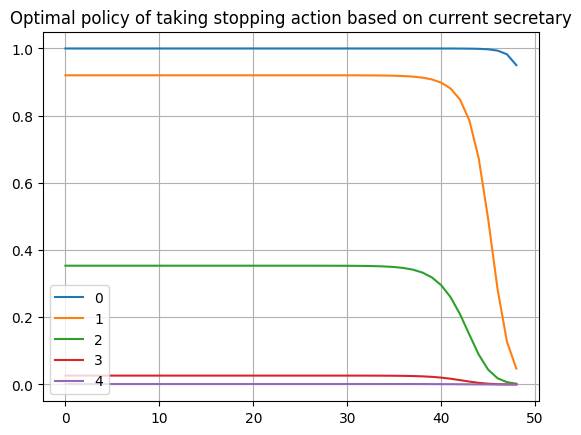

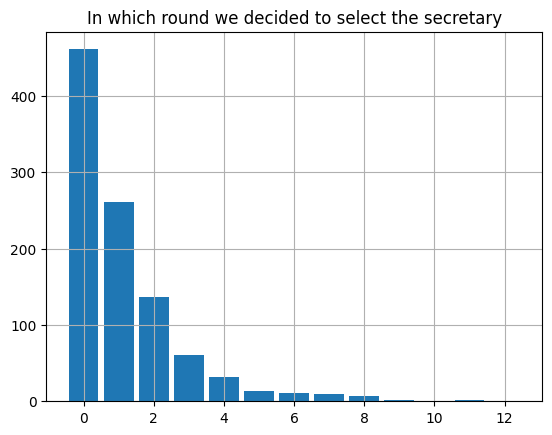

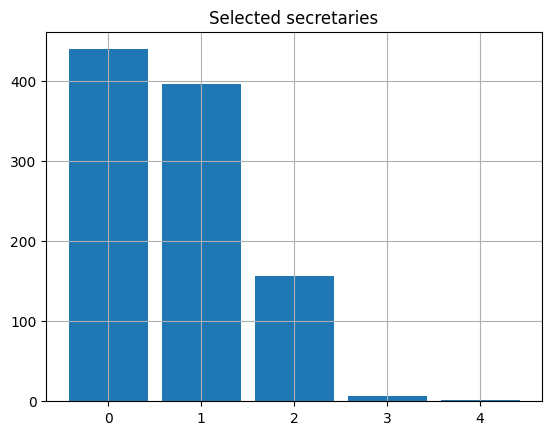

In [75]:
var = experiment2(model_gaus, model_i, num_categories, q_i3, 50, 1000)

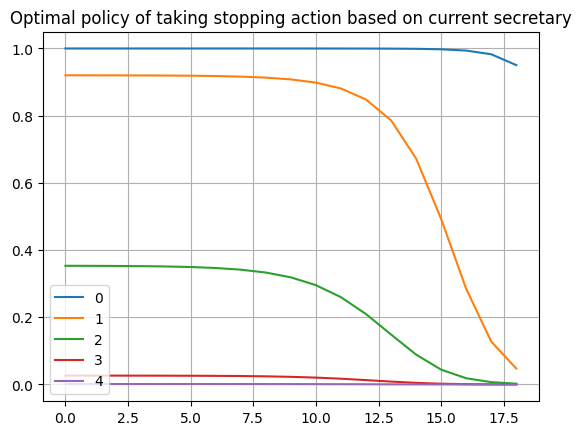

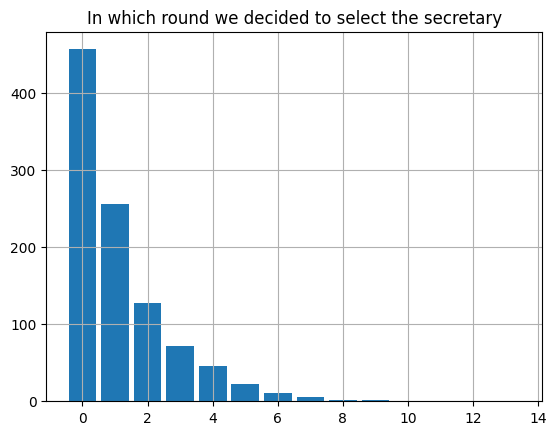

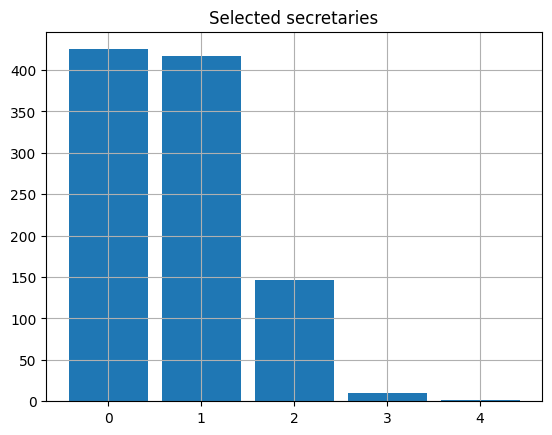

In [76]:
var = experiment2(model_gaus, model_i, num_categories, q_i3, 20, 1000)

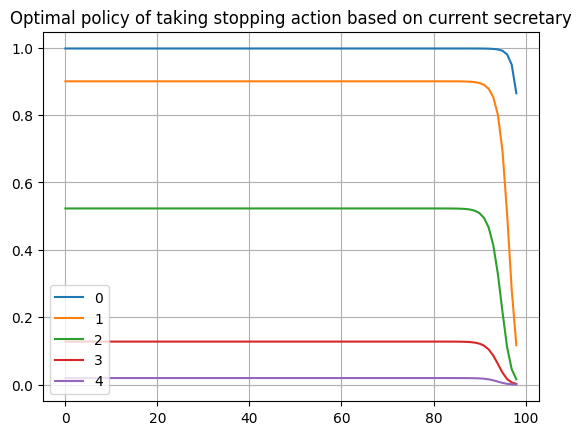

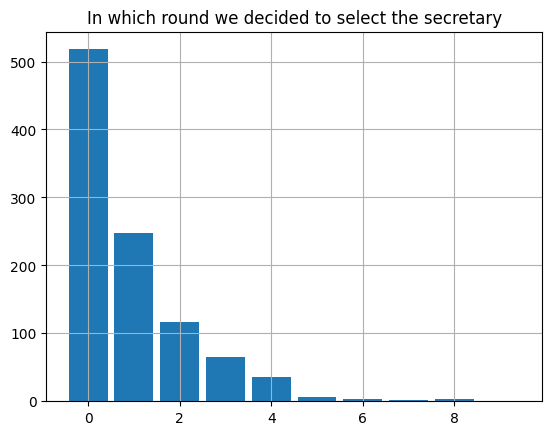

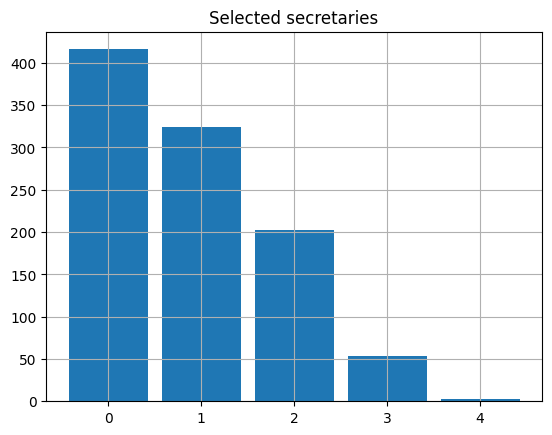

In [212]:
var = experiment2(model_gaus, model_i, 5, q_i2, 100, 1000)

In [77]:
q_i

array([0.36359135, 0.76587834, 0.91387146, 0.96831508, 0.98834377])

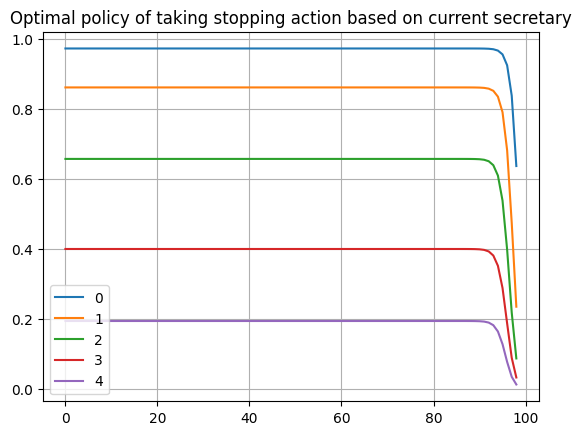

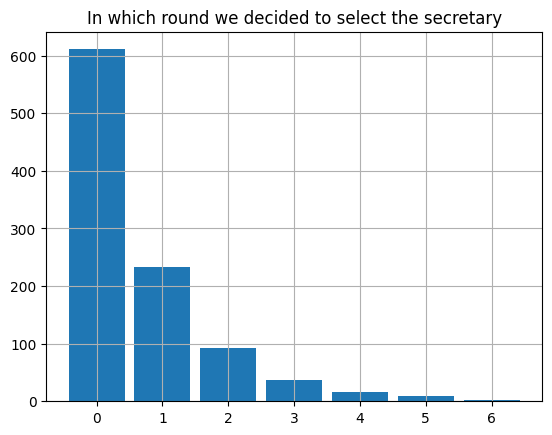

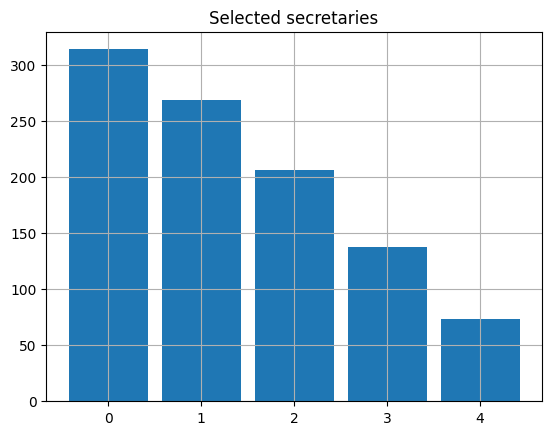

In [78]:
var = experiment2(model_gaus, model_i, num_categories, q_i, 100, 1000)

In [79]:
model_i

array([0.63640865, 0.23412166, 0.08612854, 0.03168492, 0.01165623])

In [80]:
model_i3 = np.ones(num_categories)/num_categories
model_i3

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [81]:
q_i3

array([0.04978678, 0.95269167, 0.99764466, 0.99988273, 0.99999416])

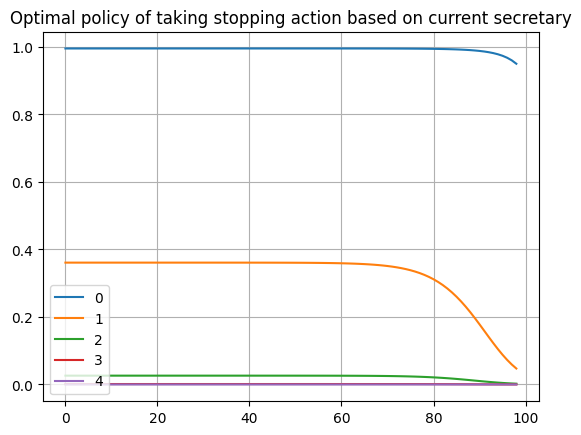

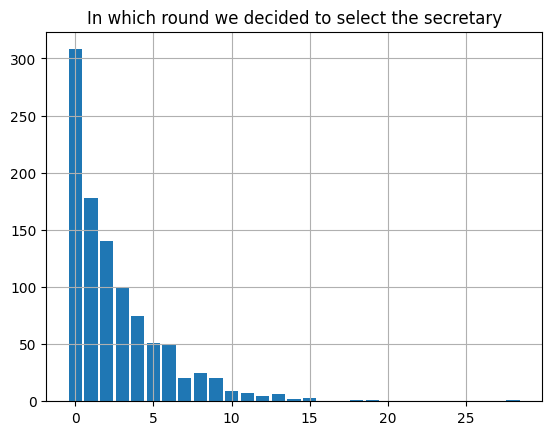

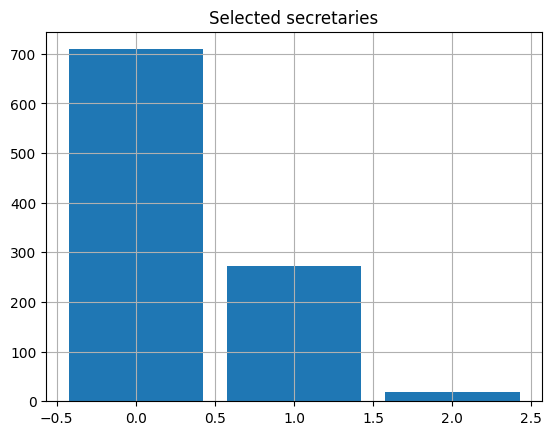

In [82]:
var = experiment2(model_gaus, model_i3, num_categories, q_i3, 100, 1000)

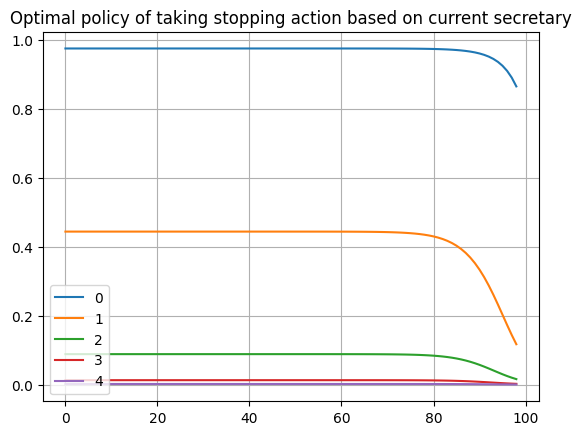

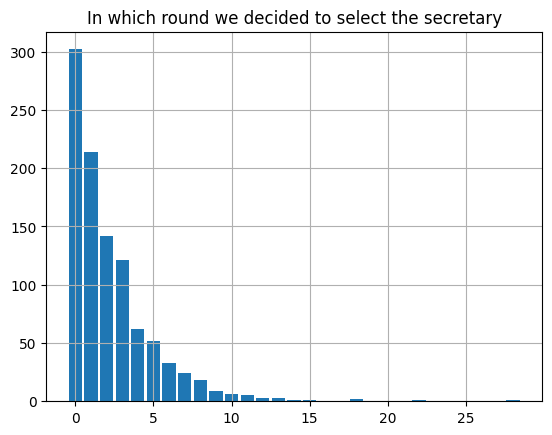

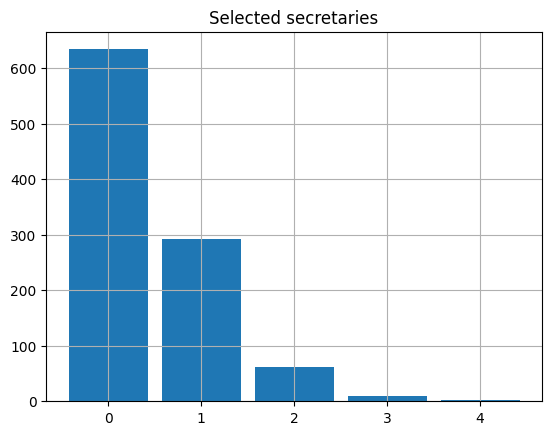

In [83]:
var = experiment2(model_gaus, model_i3, num_categories, q_i2, 100, 1000)

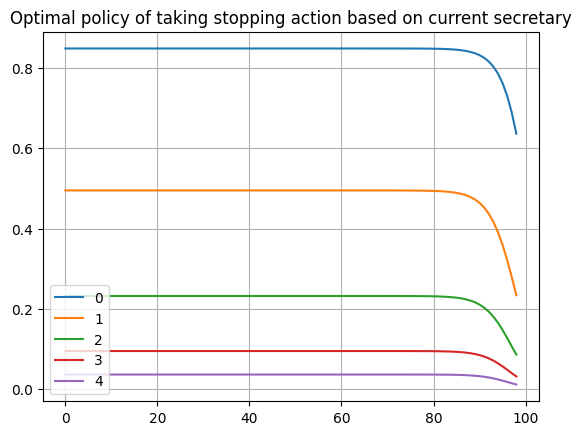

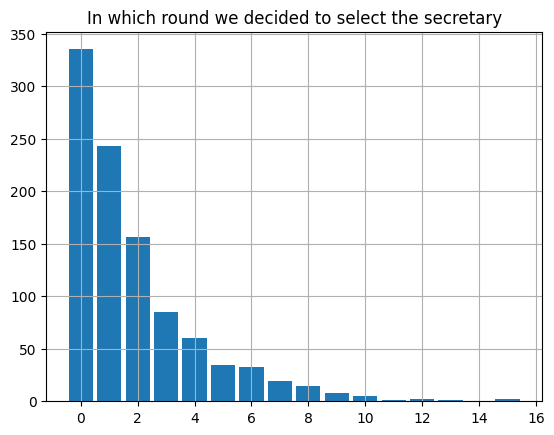

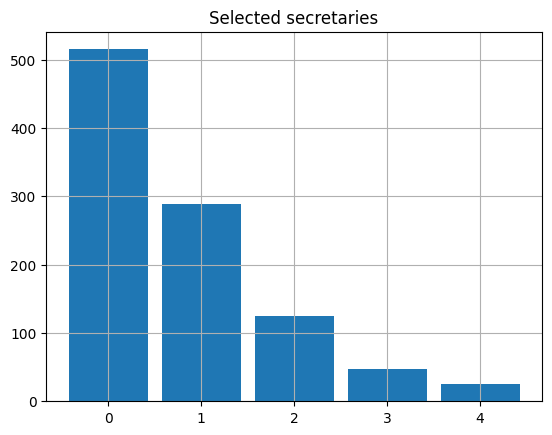

In [84]:
var = experiment2(model_gaus, model_i3, num_categories, q_i, 100, 1000)

## 10 categories

In [85]:
num_categories = 10

In [86]:
xx = np.arange(1,11,1)

In [87]:
values = expon.cdf(x=xx/10, scale=1)

In [88]:
values_norm = values/np.sum(values)
print(values_norm)

[0.02385273 0.04543558 0.06496455 0.08263509 0.09862406 0.11309147
 0.12618213 0.13802705 0.14874477 0.15844257]


In [89]:
model = values_norm

In [90]:
np.sum((xx-1)*model)

5.722446932968591

In [91]:
model

array([0.02385273, 0.04543558, 0.06496455, 0.08263509, 0.09862406,
       0.11309147, 0.12618213, 0.13802705, 0.14874477, 0.15844257])

In [92]:
xx = np.arange(1,num_categories+1,1)
print(xx)

values = 1-expon.cdf(x=xx, scale=2)

values_norm = values/np.sum(values)
print(values_norm)

np.sum(values_norm)

model_i = values_norm

[ 1  2  3  4  5  6  7  8  9 10]
[0.3961385  0.24027015 0.14573121 0.08839045 0.05361152 0.03251703
 0.01972257 0.01196235 0.00725553 0.0044007 ]


In [93]:
model_i

array([0.3961385 , 0.24027015, 0.14573121, 0.08839045, 0.05361152,
       0.03251703, 0.01972257, 0.01196235, 0.00725553, 0.0044007 ])

In [94]:
q_i = np.zeros((num_categories))

for i in range(num_categories):
  q_i[i] = 0.5 if i == 0 else q_i[i-1]/2

q_i_norm3 = q_i**2/np.sum(q_i**2)

q_i_norm3

q_i_norm = 1 - q_i_norm3

q_i_norm

q_i_norm = 1 - model_i

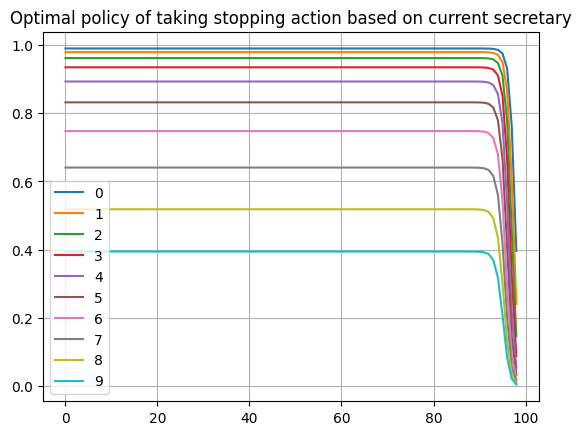

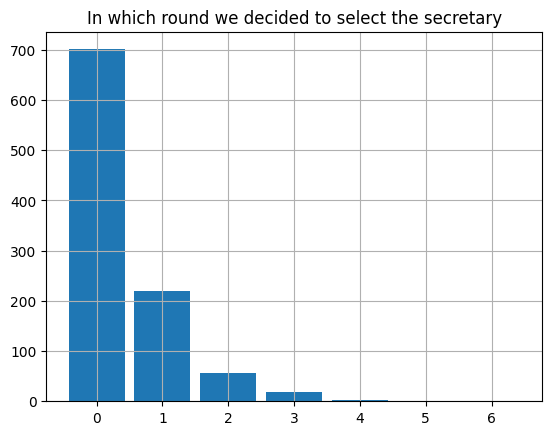

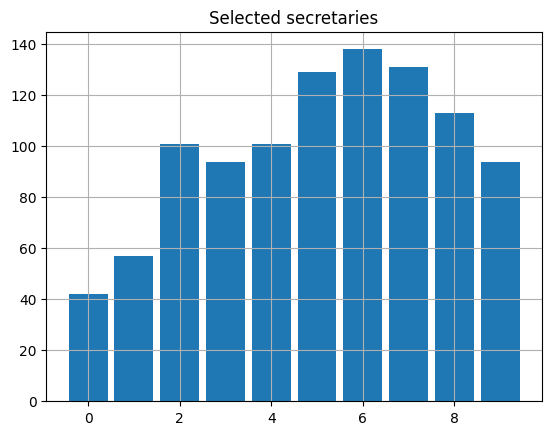

In [95]:
var = experiment2(model, model_i, num_categories, q_i_norm, 100, 1000)

In [96]:
model_2 = model + np.average(model)
model_2

array([0.12385273, 0.14543558, 0.16496455, 0.18263509, 0.19862406,
       0.21309147, 0.22618213, 0.23802705, 0.24874477, 0.25844257])

In [97]:
model_2 = model_2/np.sum(model_2)
model_2

array([0.06192637, 0.07271779, 0.08248227, 0.09131754, 0.09931203,
       0.10654574, 0.11309106, 0.11901352, 0.12437239, 0.12922128])

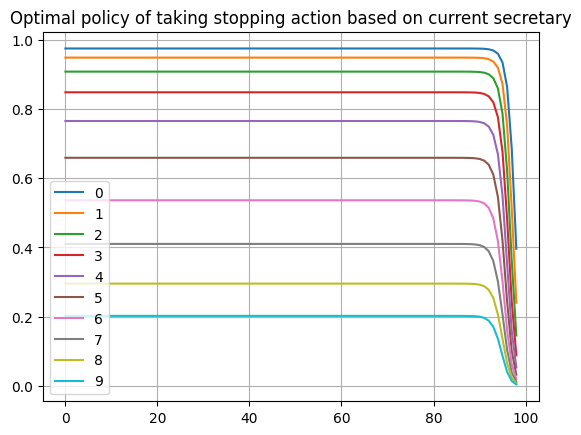

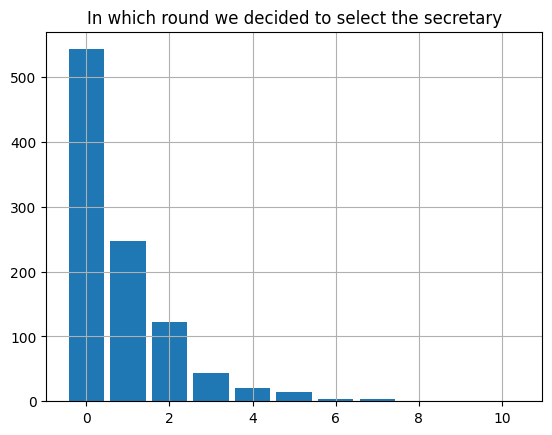

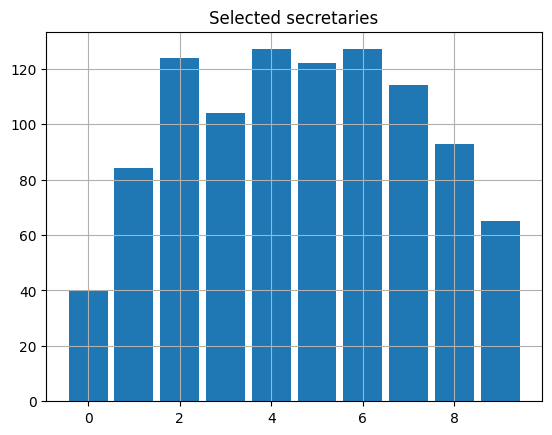

In [98]:
var = experiment2(model_2, model_i, num_categories, q_i_norm, 100, 1000)

In [99]:
model_i2 = model_i + np.average(model_i)
model_i2

array([0.4961385 , 0.34027015, 0.24573121, 0.18839045, 0.15361152,
       0.13251703, 0.11972257, 0.11196235, 0.10725553, 0.1044007 ])

In [100]:
model_i2 = model_i2/np.sum(model_i2)
model_i2

array([0.24806925, 0.17013507, 0.12286561, 0.09419522, 0.07680576,
       0.06625851, 0.05986129, 0.05598117, 0.05362776, 0.05220035])

In [101]:
model

array([0.02385273, 0.04543558, 0.06496455, 0.08263509, 0.09862406,
       0.11309147, 0.12618213, 0.13802705, 0.14874477, 0.15844257])

In [102]:
q_i_norm

array([0.6038615 , 0.75972985, 0.85426879, 0.91160955, 0.94638848,
       0.96748297, 0.98027743, 0.98803765, 0.99274447, 0.9955993 ])

In [103]:
1 - q_i_norm

array([0.3961385 , 0.24027015, 0.14573121, 0.08839045, 0.05361152,
       0.03251703, 0.01972257, 0.01196235, 0.00725553, 0.0044007 ])

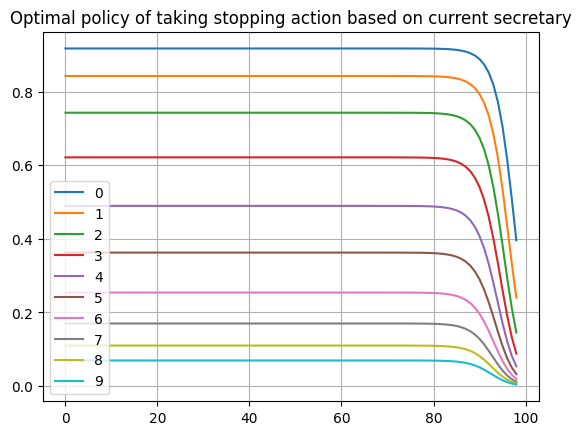

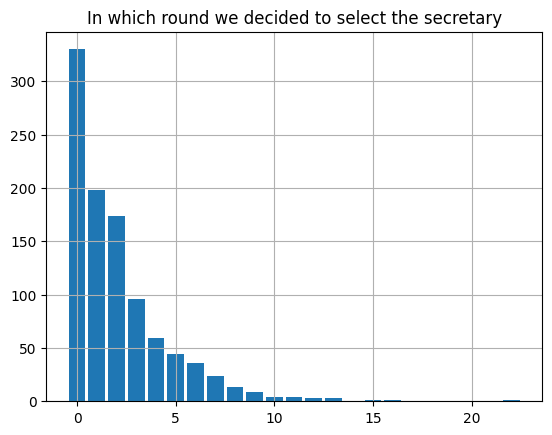

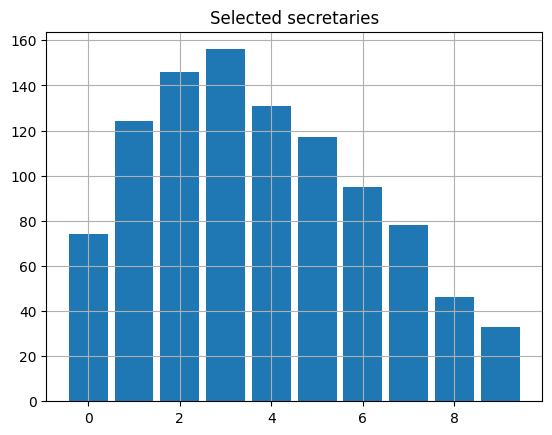

In [104]:
var = experiment2(model, model_i2, num_categories, q_i_norm, 100, 1000)

In [105]:
model_i3 = np.flip(model)
model_i3

array([0.15844257, 0.14874477, 0.13802705, 0.12618213, 0.11309147,
       0.09862406, 0.08263509, 0.06496455, 0.04543558, 0.02385273])

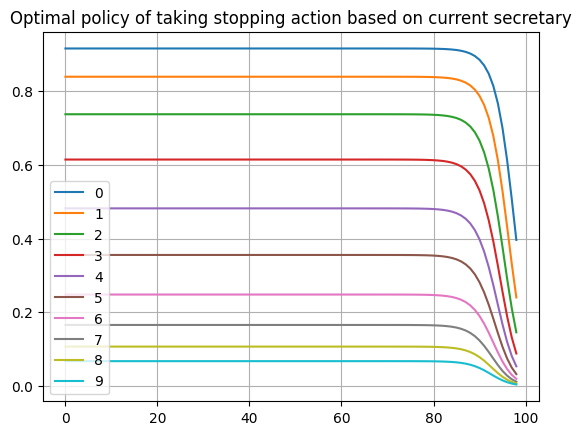

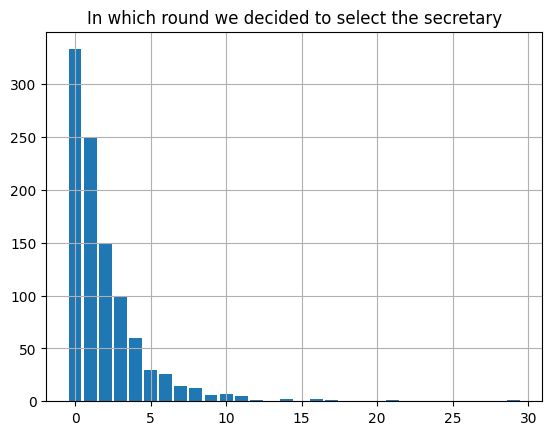

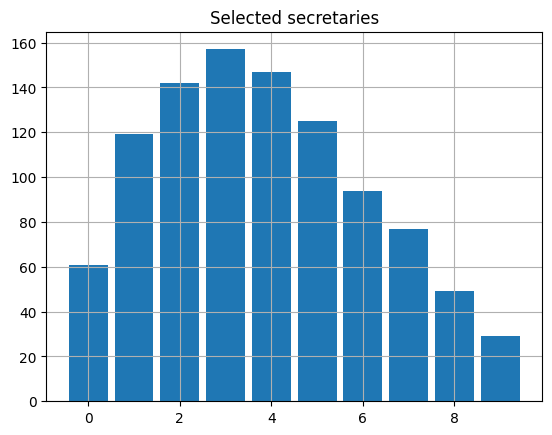

In [107]:
var = experiment2(model, model_i3, num_categories, q_i_norm, 100, 1000)

In [108]:
q_i_new = np.zeros((10))
for i in range(10):
  q_i_new[i] = 0.25 if i == 0 else q_i_new[i-1]*2

In [109]:
q_i_new = 1 - model_i**2
q_i_new

array([0.84307429, 0.94227026, 0.97876241, 0.99218713, 0.99712581,
       0.99894264, 0.99961102, 0.9998569 , 0.99994736, 0.99998063])

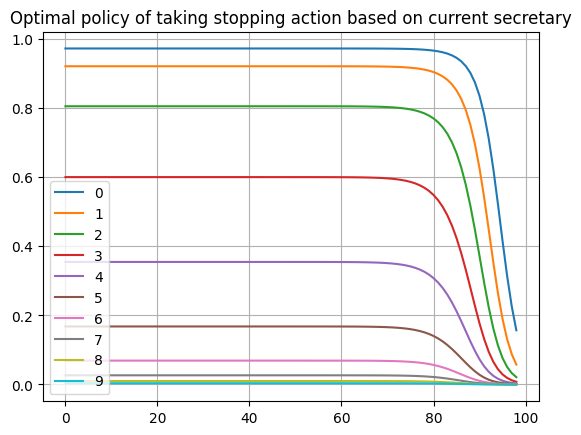

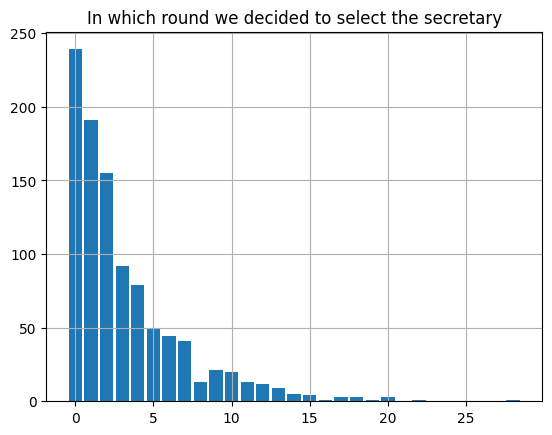

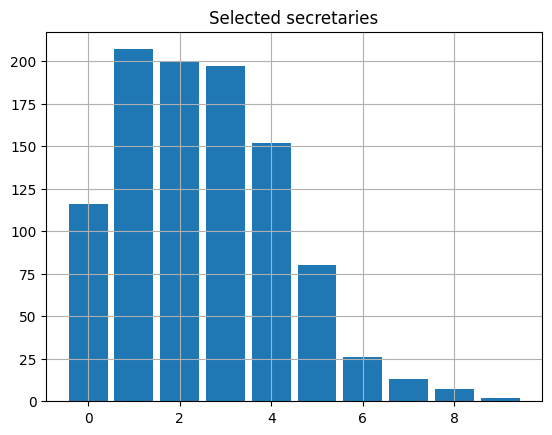

In [110]:
var = experiment2(model, model_i3, num_categories, q_i_new, 100, 1000)

## 20 categories

In [111]:
num_categories = 20

In [112]:
model = np.ones((num_categories))/num_categories

### Ideal model

In [113]:
xx = np.arange(1,num_categories+1,1)
print(xx)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [114]:
values = 1-expon.cdf(x=xx, scale=2)

In [115]:
values_norm = values/np.sum(values)
print(values_norm)

[3.93487205e-01 2.38662054e-01 1.44755853e-01 8.77988630e-02
 5.32527023e-02 3.22993966e-02 1.95905744e-02 1.18822840e-02
 7.20696955e-03 4.37124799e-03 2.65129593e-03 1.60809227e-03
 9.75357265e-04 5.91584085e-04 3.58813886e-04 2.17631623e-04
 1.32000252e-04 8.00621997e-05 4.85601788e-05 2.94532373e-05]


In [116]:
np.sum(values_norm)

1.0000000000000002

In [117]:
model_i = values_norm

### Q_i

In [118]:
q_i = np.zeros((num_categories))

In [119]:
for i in range(num_categories):
  q_i[i] = 0.5 if i == 0 else q_i[i-1]/2

In [120]:
q_i_norm3 = q_i**2/np.sum(q_i**2)

In [121]:
q_i_norm3

array([7.50000000e-01, 1.87500000e-01, 4.68750000e-02, 1.17187500e-02,
       2.92968750e-03, 7.32421875e-04, 1.83105469e-04, 4.57763672e-05,
       1.14440918e-05, 2.86102295e-06, 7.15255737e-07, 1.78813934e-07,
       4.47034836e-08, 1.11758709e-08, 2.79396772e-09, 6.98491931e-10,
       1.74622983e-10, 4.36557457e-11, 1.09139364e-11, 2.72848411e-12])

In [122]:
q_i_norm = 1 - q_i_norm3

In [123]:
q_i_norm

array([0.25      , 0.8125    , 0.953125  , 0.98828125, 0.99707031,
       0.99926758, 0.99981689, 0.99995422, 0.99998856, 0.99999714,
       0.99999928, 0.99999982, 0.99999996, 0.99999999, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [124]:
q_i_norm = 1 - model_i

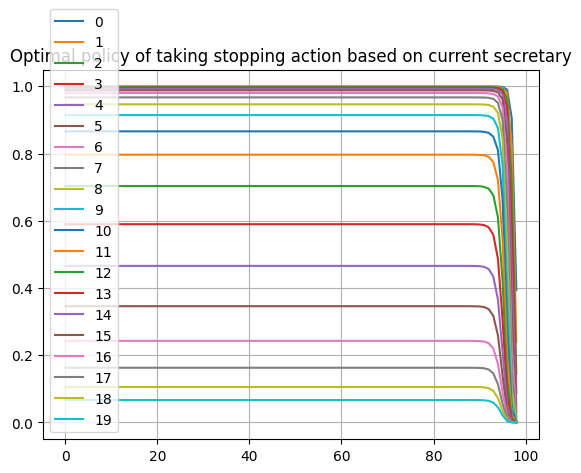

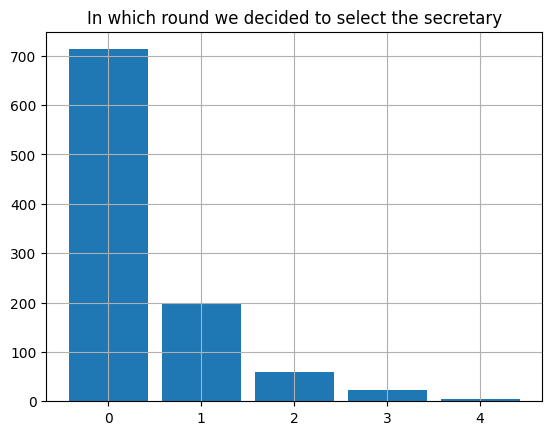

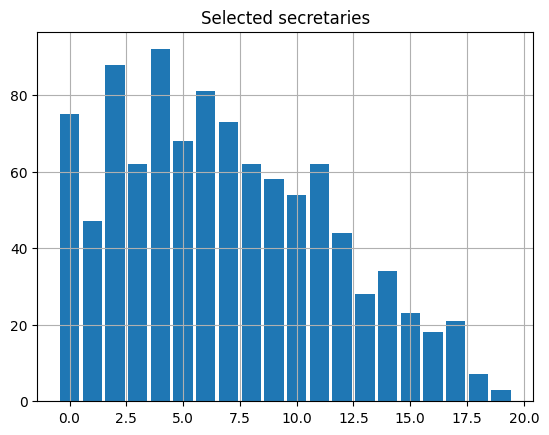

In [125]:
var = experiment2(model, model_i, num_categories, q_i_norm, 100, 1000)

In [126]:
q_i_norm2 = q_i_norm**2
q_i_norm2

array([0.36785777, 0.57963547, 0.73144255, 0.83211091, 0.89633045,
       0.93644446, 0.96120264, 0.97637662, 0.985638  , 0.99127661,
       0.99470444, 0.9967864 , 0.99805024, 0.99881718, 0.9992825 ,
       0.99956478, 0.99973602, 0.99983988, 0.99990288, 0.99994109])

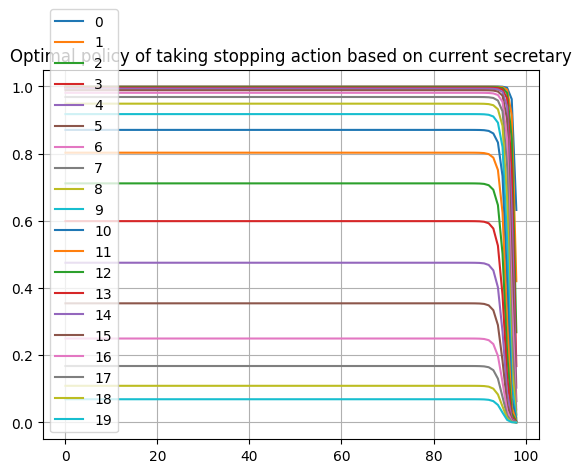

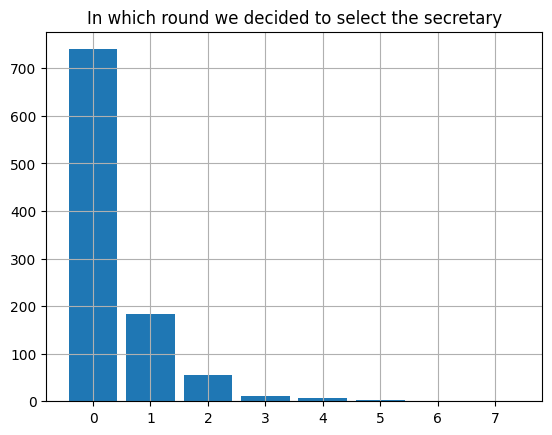

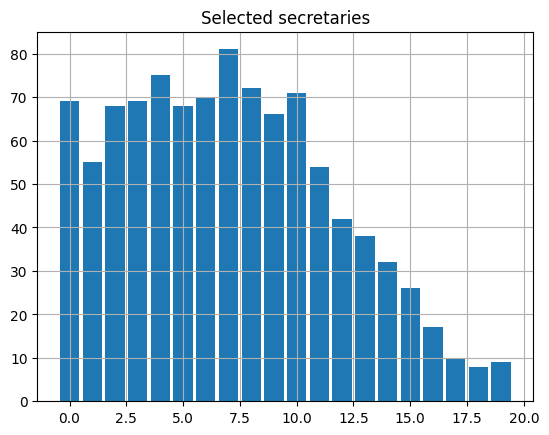

In [127]:
var = experiment2(model, model_i, num_categories, q_i_norm2, 100, 1000)

In [128]:
values = 1-expon.cdf(x=xx, scale=2)

In [129]:
values_norm = values/np.sum(values)
print(values_norm)

[3.93487205e-01 2.38662054e-01 1.44755853e-01 8.77988630e-02
 5.32527023e-02 3.22993966e-02 1.95905744e-02 1.18822840e-02
 7.20696955e-03 4.37124799e-03 2.65129593e-03 1.60809227e-03
 9.75357265e-04 5.91584085e-04 3.58813886e-04 2.17631623e-04
 1.32000252e-04 8.00621997e-05 4.85601788e-05 2.94532373e-05]


In [130]:
np.sum(values_norm)

1.0000000000000002

In [131]:
model_i = values_norm